In [11]:
import os
import sys
from IPython.display import clear_output
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# import the cfe model
import bmi_cfe
import cfe

In [12]:
# define working dir
working_dir = '/Users/Sophie/Desktop/CUAHSI/nextgen-form-eval/Calibration'

# define basin list dir
basin_dir = '/Users/Sophie/Desktop/CUAHSI/Data'
basin_filename = 'basin_list_516.txt'
basin_file = os.path.join(basin_dir,basin_filename)

# define config dir
config_dir = os.path.join(working_dir,'configs')

# define observation file dir
#obs_dir = os.path.join(working_dir,'usgs-streamflow')
obs_dir = '/Users/Sophie/Desktop/CUAHSI/Data'


In [13]:
# load basin list
with open(basin_file, "r") as f:
    basin_list = pd.read_csv(f, header=None)

###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/Data/02231000_hourly_nldas.csv. -----###
###----- nldas forcing data length: 52608------###
---------------- Current Timestep: 100----------------
rainfall_input: 1.5327e-09 m. 
pet: 2.8795e-05 m.
reduced et: 2.8795e-05 m. 

after rainfall et: 
rainfall_input: 0.0000e+00 m 
et from rain: 1.5327e-09 m
reduced et: 2.8794e-05 m
soil storage: 5.6168e-01 m
total out vol: 2.2063e-02 m

after soil et: 
rainfall_input: 0.0000e+00 m 
et from soil: 2.8794e-05 m
soil storage: 5.6166e-01 m
soil storage deficit: 2.2254e-01
total out vol: 2.2092e-02 m,

After direct runoff function: 
rain: 0.0000e+00 m,
runoff/timestep: 0.0000e+00 m,
soil storage: 5.6166e-01 m
soil storage deficit: 2.2254e-01
runoff volume: 3.9839e-04 m,
infiltration volume: 5.0153e-02 m,
residual:0.0000e+00 m 

after previous step percolation: 
soil storage: 5.6166e-01 m
soi

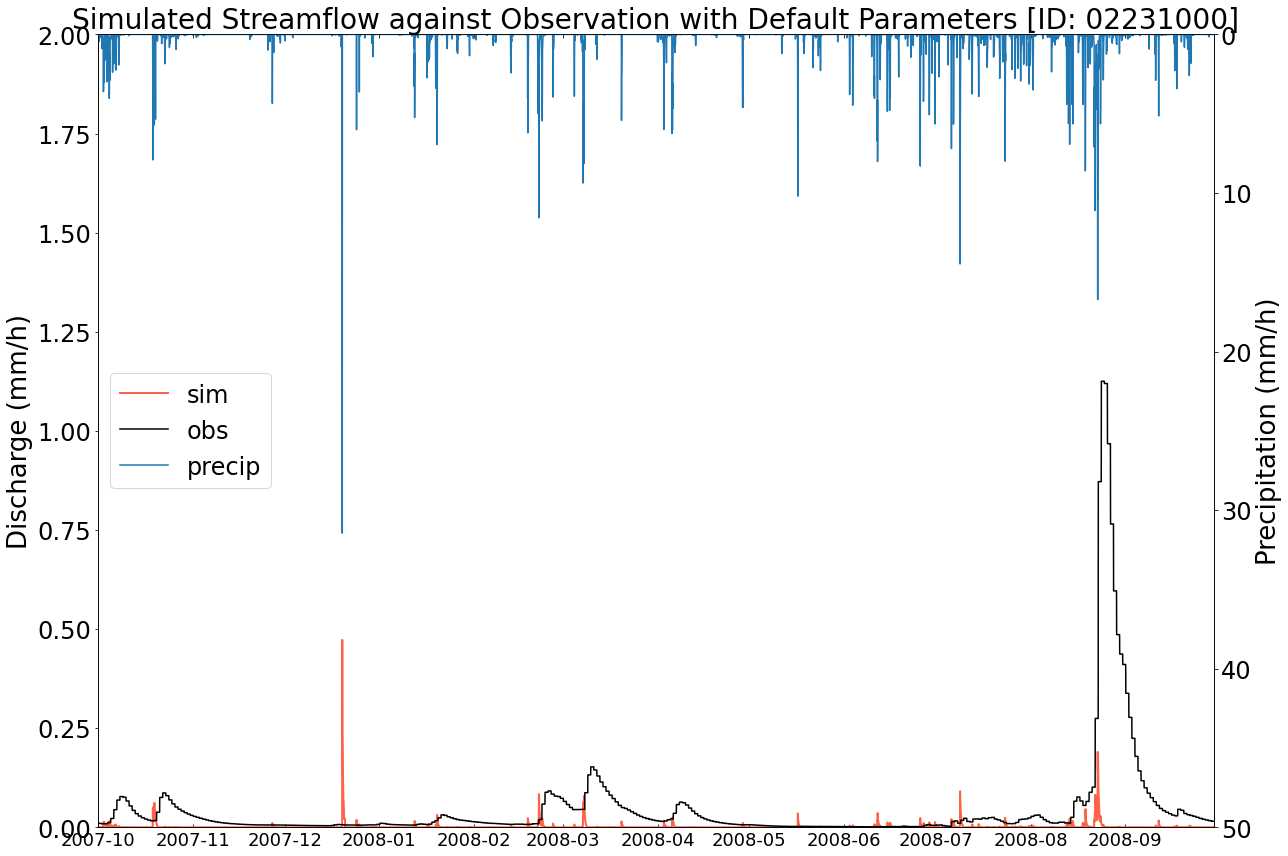

In [14]:
# Loop through each basin
for i in range(basin_list.shape[0]): 
# for i in range(20): 
    # if i == 1 : break             # run for the first basin in the list

    if i != 130: continue           # run for a specific basin in the list

    clear_output()
    
    g = basin_list[0][i]

    # locate config file
    config_filename = 'cat_' + str(g) + '_bmi_config_cfe.json'
    config_file = os.path.join(config_dir,config_filename)

    # ----------------------------------- Run the Model ----------------------------------- #

    cfemodel = bmi_cfe.BMI_CFE(config_file)
    print('###--------model succesfully setup----------###')

    scheme = "Xinanjiang"

    cfemodel.initialize(param_vec = [], scheme = "Schaake")
    print('###--------model succesfully initialized----------###')

    with open(cfemodel.forcing_file, 'r') as f:
        df_forcing = pd.read_csv(f)
    print(f"###----- forcing_file loaded:{cfemodel.forcing_file}. -----###")

    # define the calibration period for nldas forcing and usgs streamflow obs.
    cal_start_idx_nldas = np.where(df_forcing['date']=='2007-10-01 00:00:00')
    cal_end_idx_nldas = np.where(df_forcing['date'].values=='2013-09-30 23:00:00')
    df_forcing = df_forcing.iloc[cal_start_idx_nldas[0][0]:cal_end_idx_nldas[0][0]+1,:]

    print('###----- nldas forcing data length: ' +  str(len(df_forcing['date'].values))+"------###")

    outputs=cfemodel.get_output_var_names()
    output_lists = {output:[] for output in outputs}

    for precip, pet, temp, netrad in zip(df_forcing['total_precipitation'],df_forcing['potential_evaporation'],df_forcing['temperature'],(df_forcing['shortwave_radiation']+df_forcing['longwave_radiation'])):
        #print(f"###----------loaded precip, pet: {precip},{pet}.------------###")
        #sys.exit(1)

        # ----------- Priestley-Taylor PET calculation --------------------#
        # cfemodel.timestep_temp_degC = temp
        # cfemodel.timestep_netrad_watt_per_m2 = netrad
        # cfemodel.eas = 611 * np.exp((17.27*cfemodel.timestep_temp_degC) / (237.3 + cfemodel.timestep_temp_degC)) # Pa
        # cfemodel.delta = 4098 * cfemodel.eas / ((237.3 + cfemodel.timestep_temp_degC) ** 2) #Pa/degC
        # cfemodel.Er = 0.0353 * cfemodel.timestep_netrad_watt_per_m2 # %added lines% netrad  
        # cfemodel.potential_et_m_per_s = (1/1000) / (24*60*60) * 1 *  cfemodel.Er * \
        #     (cfemodel.delta/(cfemodel.delta+66.8)) # PET in m/s
    
        cfemodel.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip/1000)   # kg/m2/h = mm/h -> m/h
        cfemodel.set_value('water_potential_evaporation_flux', pet/1000/3600) # kg/m2/h = mm/h -> m/s
        cfemodel.update()

        for output in outputs:
            output_lists[output].append(cfemodel.get_value(output))
        
    cfemodel.finalize(print_mass_balance=True)

    # ----------------------------------- Evaluate Results ----------------------------------- #
    # Load Observation file
    obs_filename = '0' + str(g) + '-usgs-hourly.csv'
    obs_file = os.path.join(obs_dir,obs_filename)

    data = pd.read_csv(obs_file)
    obs_data = data['QObs_CAMELS(mm/h)'].values
    eval_dates = data['date'].values

    # define calibration period for usgs streamflow obs.
    cal_start_idx_usgs = np.where(eval_dates=='2007-10-01 00:00:00')
    cal_end_idx_usgs = np.where(eval_dates=='2013-09-30 23:00:00')
    eval_dates = eval_dates[cal_start_idx_usgs[0][0]:cal_end_idx_usgs[0][0]+1]
    obs_data = obs_data[cal_start_idx_usgs[0][0]:cal_end_idx_usgs[0][0]+1]
    
    dates = [pd.Timestamp(eval_dates[i]) for i in range(len(eval_dates))]

    # Export streamflow data
    sims = np.array(output_lists['land_surface_water__runoff_depth']) * 1000 

    fig, ax1 = plt.subplots(figsize = (18,12)) 
    p1, = ax1.plot(dates[0:8760],sims[0:8760],'tomato', linewidth = 2,label = "sim")
    p2, = ax1.plot(dates[0:8760],obs_data[0:8760],'k',label = "obs")
    ax1.set_ylabel('Discharge (mm/h)',fontsize = 26)
    ax1.set_ylim([0,2])
    ax1.tick_params(axis='x', labelsize= 18)
    ax1.tick_params(axis='y', labelsize= 24)
    ax1.margins(x=0)
    ax1.xaxis.set_ticks_position('both')
    ax1.xaxis.set_label_position('bottom')
    ax1.tick_params(axis="x",direction="in")
    ax2 = ax1.twinx()
    p3, = ax2.plot(dates[0:8760],df_forcing['total_precipitation'][0:8760],'tab:blue', label = "precip")
    ax2.set_ylim([50,0])
    ax2.margins(x=0)
    #ax2.invert_yaxis()
    ax2.set_ylabel('Precipitation (mm/h)',fontsize = 26)
    ax2.set_xlabel('Date', fontsize = 18)
    #ax2.tick_params(axis='x', labelsize= 24)
    ax2.tick_params(axis='y', labelsize= 24)
    plt.legend(handles = [p1,p2,p3],fontsize = 24, loc='center left', bbox_to_anchor=(0., 0.5))
    plt.title(f"Simulated Streamflow against Observation with Default Parameters [ID: 0{g}]", fontsize = 28)
    plt.tight_layout()
    plt.show()

In [15]:
#%pip install hydroeval
import hydroeval as he

simulations = sims
evaluations = obs_data

#nse = he.evaluator(he.nse, simulations, evaluations)

kge, r, alpha, beta = he.evaluator(he.kge, simulations, evaluations)

print(kge)

[-0.55674175]


In [16]:
sims.shape
obs_data.shape

(52608,)

In [17]:
cfemodel.alpha_fc

0.33

In [18]:
cfemodel.soil_reservoir

{'is_exponential': False,
 'wilting_point_m': 0.04355590428301887,
 'storage_max_m': 0.7841921952075473,
 'coeff_primary': 0.02274330925738765,
 'exponent_primary': 1.0,
 'storage_threshold_primary_m': 0.3534543653384922,
 'coeff_secondary': 0.01,
 'exponent_secondary': 1.0,
 'storage_threshold_secondary_m': 0.3534543653384922,
 'storage_m': 0.26225357111497505}

In [19]:
cfemodel.soil_params

{'bb': 4.5,
 'D': 2.0,
 'depth': 2.0,
 'mult': 1000.0,
 'satdk': 6.897515094339623e-05,
 'satpsi': 0.10682786983962264,
 'slop': 0.0915922012264151,
 'smcmax': 0.3920960976037737,
 'wltsmc': 0.021777952141509436}

In [20]:
cfemodel.precip_check_before_run[60:70]

[1.64784921983962e-05,
 0.0001079515566887502,
 1.5542887029288e-06,
 0.0,
 1.689475825197584e-08,
 0.0,
 1.689475825197584e-08,
 2.8499825662482568e-08,
 4.9905639818688e-06,
 8.791721437703349e-05]